# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT or preliminary** if no corrections, offsets or time bounds are applied but none/some meta data is, this is an internally hosted dataset for primary analysis, quick review, and historical purposes.
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot, often has deck data removed.  It is usually a combination of editable csv files and archivable netcdf files
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information.  Used for distribution and science analysis

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

## Example below is for RCM-9 but the workflow is similar for any non-seaguard instruments.


Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

<div class="alert alert-danger">
  RCM 7/9/11 units have some onboard calibrations which just have to have a scale factor applied, and some calibrations that have a complex transformation.
    Additionally, oxygen sensors need to be corrected for salinity
    
  RCM Seaguards output converted values explicitly (no transformations) but still need salinity and pressure corrections to the oxygen optodes.
</div>


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import EcoFOCIpy.io.rcm_parser as rcm_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config
import EcoFOCIpy.math.geotools as geotools

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2021/Moorings/21ckp12a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'rawconverted/rcm/21ckp12a_rcm9_651.txt'
instrument = 'RCM9 651'
mooring_meta_file = user_data_dir+'logs/21CKP-12A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/rcm_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 'an9'
###############################################################

#init and load data
rcm_wop = rcm_parser.rcm()
rcm_wop_data = rcm_wop.parse(filename=datafile,number_of_channels=7,time_format=1,datetime_index=True) 
rcm_wop_data

,sample,ident,speed_engr,dir_engr,temp_engr,cond_engr,press_engr,chan7
date_time,,,,,,,,
2021-11-09 20:00:00,0,7,21,11,9,20,0,NaN
2021-11-09 20:00:00,1,169,0,0,996,0,21,501.0
2021-11-09 21:00:00,2,169,133,90,991,0,21,490.0
2021-11-09 22:00:00,3,169,95,212,983,0,21,490.0
2021-11-09 23:00:00,4,169,120,288,976,0,22,491.0
...,...,...,...,...,...,...,...,...
2022-10-24 00:03:00,8706,169,147,419,879,0,22,516.0
2022-10-24 01:03:00,8707,169,100,484,918,0,22,502.0
2022-10-24 02:03:00,8708,169,102,349,942,0,22,492.0


In [4]:
rcm_wop.drop_headerrows(ident=169) #does not return any values

## Add Deployment meta information

- this step is necessary first in order to calculate the declination correction for the currents

In [5]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [6]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'RCM9',
 'SerialNo': '651',
 'DesignedDepth': 58.0,
 'ActualDepth': 54.0,
 'PreDeploymentNotes': 'Started 2000Z on 09 Nov 21',
 'PostDeploymentNotes': 'Stop on 2022-10-24 03:27:20',
 'Deployed': 'y',
 'Recovered': 'y'}

In [7]:
print(f"Deployment Lat: {mooring_config['Deployment']['DeploymentLatitude']}")
print(f"Deployment Lon: {mooring_config['Deployment']['DeploymentLongitude']}")
print(f"Deployment Date: {mooring_config['Deployment']['DeploymentDateTimeGMT'].date()}")

#some parsing/cleaning for functions
latlon_dec = geotools.latlon_convert(mooring_config['Deployment']['DeploymentLatitude'],
                        mooring_config['Deployment']['DeploymentLongitude'])
dep_date = mooring_config['Deployment']['DeploymentDateTimeGMT'].date()

Deployment Lat: 67 54.507 N
Deployment Lon: 168 11.926 W
Deployment Date: 2021-11-12


In [8]:
#convert the currents and calculate the declination correction
rcm_wop.engr2sci_curr()
rcm_wop_data,dec_cor = rcm_wop.mag_dec_corr(latlon_dec[0],latlon_dec[1],dep_date,apply_correction=True)


/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/rcm_parser.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.rawdata_df['current_speed'] = self.rawdata_df['speed_engr']*0.2933
/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/rcm_parser.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.rawdata_df['current_direction_uncorrected'] = self.rawdata_df['dir_engr']*0.3515
/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/rcm_parser.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

## Apply Temp/Press/Cond/Turb/Oxygen Calibration info

As mentioned, Temperature, Pressure, Conductivity, and Turbidity have calibration equations that need to be applied (and the pressure version can be of varying units)

Oxygen is just scaled to get uM

<div class="alert alert-danger">
  <strong>Calibration Informtation from 2011 Documents</strong>
</div>


In [9]:
#oxygen
rcm_wop.engr2sci_oxy(channel='chan7')
rcm_wop.engr2sci_temp(coefA=-2.745,coefB=2.411e-02,coefC=-2.238e-06,coefD=2.056e-9) #low temp setting
rcm_wop.engr2sci_pres(coefA=-5.506e01,coefB=3.502e0,coefC=6.297e-05,equationType='low') #kpa
#cond/turb not usually used so not implimented

/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/rcm_parser.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.rawdata_df['oxy_conc'] = self.rawdata_df['chan7']*0.4883
/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/rcm_parser.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.rawdata_df['temperature'] = coefA + coefB*self.rawdata_df['temp_engr'] + \
/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/rcm_parser.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

The can be classified into two categories:
+ interpolate: these change the parameter values in accordance with the time edits
    - linear interpolation is most common
    - averaging of data and rebinning/resampling is also common (this needs to have the "time lable" thought out...)
    - decimating is less common but does not impact the max/min values
+ shift: these do not alter the measurements, just the timestamps they are associated with
    - the round function will work well to correct small time errors/drifts **common**
    - dropping extra precision on time (if you want hourly measurements, just remove all minute/second info... could cause large errors if rounding would have been more appropriate)

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean() but it will label the new datapoint per default instructions.  The default is to label it with the left boundary of the bin.
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift (round)
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
        - you may also be able to *shift* using the pandas datetime round function and specifing the desired frequency.
    + I suggest if no change is needed... df.index.round(freq=*'your native sample freq'*)
    

In [10]:
rcm_wop_data.index = rcm_wop_data.index.round(freq='1H')
rcm_wop_data

,sample,ident,speed_engr,dir_engr,temp_engr,cond_engr,press_engr,chan7,current_speed,current_direction_uncorrected,u_curr_comp,v_curr_comp,oxy_conc,temperature,pressure
date_time,,,,,,,,,,,,,,,
2021-11-09 20:00:00,1,169,0,0,996,0,21,501.0,0.0000,0.0000,0.000000,0.000000,244.6383,21.079855,-8.149023
2021-11-09 21:00:00,2,169,133,90,991,0,21,490.0,39.0089,31.6350,24.298007,30.517227,239.2670,20.951099,-8.149023
2021-11-09 22:00:00,3,169,95,212,983,0,21,490.0,27.8635,74.5180,27.550942,4.161759,239.2670,20.745492,-8.149023
2021-11-09 23:00:00,4,169,120,288,976,0,22,491.0,35.1960,101.2320,33.449764,-10.948593,239.7553,20.565987,-7.798552
2021-11-10 00:00:00,6,169,98,158,971,0,22,491.0,28.7434,55.5370,25.479246,13.303799,239.7553,20.437997,-7.798552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-23 23:00:00,8704,169,140,446,822,0,22,541.0,41.0620,156.7690,11.551544,-39.403676,264.1703,16.703167,-7.798552
2022-10-24 00:00:00,8706,169,147,419,879,0,22,516.0,43.1151,147.2785,18.785000,-38.807675,251.9628,18.114855,-7.798552
2022-10-24 01:00:00,8707,169,100,484,918,0,22,502.0,29.3300,170.1260,1.525800,-29.290286,245.1266,19.092528,-7.798552


<Axes: xlabel='date_time'>

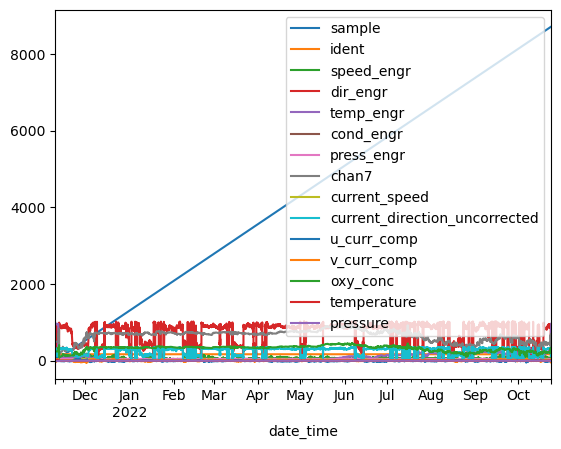

In [11]:
rcm_wop_data.plot()

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [12]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [13]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [14]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
rcm_wop_nc = ncCFsave.EcoFOCI_CFnc(df=rcm_wop_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
rcm_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [15]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
rcm_wop_nc.expand_dimensions()

In [16]:
#build list from columsn in data - if a variable isn't in the yaml file, it will be dropped from the final data fields
rcm_wop_nc.variable_meta_data(variable_keys=list(rcm_wop_data.columns.values),drop_missing=True)
rcm_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
rcm_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [17]:
#add global attributes
rcm_wop_nc.deployment_meta_add()
rcm_wop_nc.get_xdf()

#add instituitonal global attributes
rcm_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
rcm_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
rcm_wop_nc.provinance_meta_add()

#provide intial qc status field
rcm_wop_nc.qc_status(qc_status='unknown')


In [18]:
rcm_wop_nc.get_xdf()

<xarray.Dataset>
Dimensions:        (time: 8360, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 2021-11-09T20:00:00 ... 2022-10-24T0...
  * latitude       (latitude) float64 67.91
  * longitude      (longitude) float64 -168.2
  * depth          (depth) float64 54.0
Data variables:
    current_speed  (time, depth, latitude, longitude) float64 0.0 39.01 ... 39.3
    u_curr_comp    (time, depth, latitude, longitude) float64 0.0 ... -7.315
    v_curr_comp    (time, depth, latitude, longitude) float64 0.0 ... -38.62
    oxy_conc       (time, depth, latitude, longitude) float64 244.6 ... 236.8
    temperature    (time, depth, latitude, longitude) float64 21.08 ... 20.23
    pressure       (time, depth, latitude, longitude) float64 -8.149 ... -7.799
Attributes: (12/32)
    Latitude_DegMMddW:                      67 54.507 N
    Longitude_DegMMddN:                     168 11.926 W
    MooringID:                              21CKP-12A
    platform_deployment_date:               2021-11-12T13:00:00Z
    platform_deployment_cruise_name:        SKQ2021-15S
    platform_recovery_date:                 2022-10-23T18:57:00Z
    ...                                     ...
    acknowledgement:                        
    InstrumentSerialNumber:                 651
    InstrumentType:                         RCM9
    date_created:                           2024-02-07T08:45:53Z
    date_modified:                          
    QC_indicator:                           unknown

## Salinity and Depth corrections to Oxygen

FOCI sets (or keeps) all aanderaa salinity sensors at 0-PSU (factory) for simplicity and consistency and applies the salinity correction after recovery, also, we tend to report in um/kg as opposed to um/l (or Molar) so do the unit conversion too. And finally, the actual measurement made is partial pressure/ percent saturation.  Report that as well (may need to calculate it)

There was a sbe16 on this site that can be used: 
 - Given statistics above, a constant salinity correction for the oxygen sensor is acceptable. Choose **XX**
 
Or

 - choose based off of CTD cast on deployment/recovery **32.95**

In [19]:
from EcoFOCIpy.math import aandopt_oxy_corr as aand_oxy

# if you just want to correct and move on - pass the trimmed data in e.g. : sbe16_wop_nc.autotrim_time().oxy_conc
# if you want to evaluate deck info - pass the untrimmed data in e.g. : sbe16_wop_nc.get_xdf().oxy_conc

#depth correction... usually small
temp_oxycorr = aand_oxy.o2_dep_comp(oxygen_conc=rcm_wop_nc.get_xdf().oxy_conc,
                     depth=int(mooring_config['Instrumentation'][instrument]['ActualDepth']))

#sal correction... big! will need to come from a different isntrument or be a lucky guess
temp_oxycorr = aand_oxy.o2_sal_comp(oxygen_conc=temp_oxycorr,
                                    salinity=rcm_wop_nc.get_xdf().temperature*0+32.95,
                                    temperature=rcm_wop_nc.get_xdf().temperature)

#units adjustment... not so big from uM to um/kg
temp_oxycorr_umkg = aand_oxy.o2_molar2umkg(oxygen_conc=temp_oxycorr,
                                           salinity=rcm_wop_nc.get_xdf().temperature*0+32.95,
                                           temperature=rcm_wop_nc.get_xdf().temperature,
                                           pressure=int(mooring_config['Instrumentation'][instrument]['ActualDepth']))

#saturation calculation
temp_oxysat = aand_oxy.o2_percent_sat(oxygen_conc=temp_oxycorr,
                                           salinity=rcm_wop_nc.get_xdf().temperature*0+32.95,
                                           temperature=rcm_wop_nc.get_xdf().temperature,
                                           pressure=int(mooring_config['Instrumentation'][instrument]['ActualDepth']))

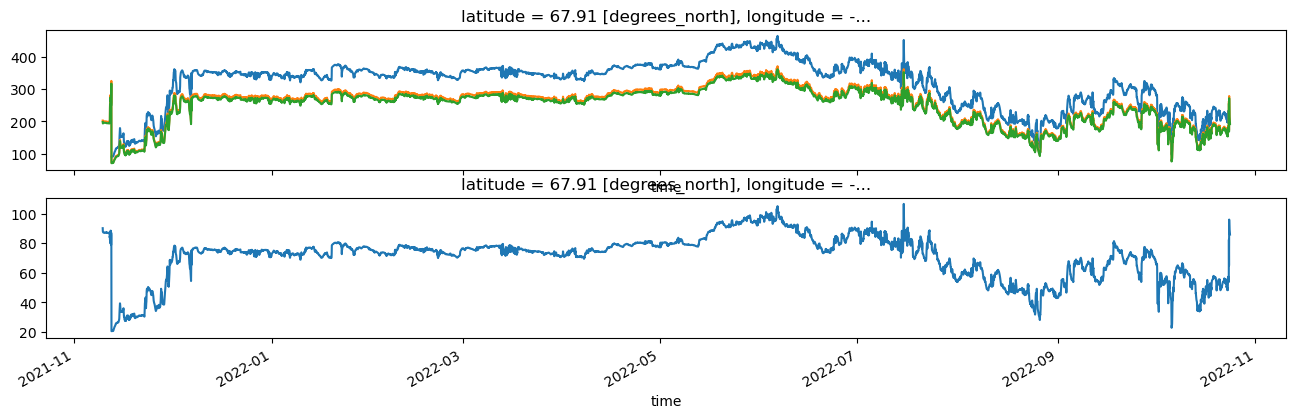

In [20]:
fig, ax = plt.subplots(2,figsize=(16, 4),sharex=True)
rcm_wop_nc.autotrim_time().oxy_conc.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
temp_oxycorr.plot(ax=ax[0])
temp_oxycorr_umkg.plot(ax=ax[0])
temp_oxysat.plot(ax=ax[1])


looking at the deck portion at the start of the deployment indicates an approximate offset of ~10percent?

In [21]:
#depth correction... usually small
temp_oxycorr = aand_oxy.o2_dep_comp(oxygen_conc=rcm_wop_nc.autotrim_time().oxy_conc,
                     depth=int(mooring_config['Instrumentation'][instrument]['ActualDepth']))

#sal correction... big! will need to come from a different isntrument or be a lucky guess
temp_oxycorr = aand_oxy.o2_sal_comp(oxygen_conc=temp_oxycorr,
                                    salinity=rcm_wop_nc.autotrim_time().temperature*0+32.95,
                                    temperature=rcm_wop_nc.autotrim_time().temperature)

#units adjustment... not so big from uM to um/kg
temp_oxycorr_umkg = aand_oxy.o2_molar2umkg(oxygen_conc=temp_oxycorr,
                                           salinity=rcm_wop_nc.autotrim_time().temperature*0+32.95,
                                           temperature=rcm_wop_nc.autotrim_time().temperature,
                                           pressure=int(mooring_config['Instrumentation'][instrument]['ActualDepth']))

#saturation calculation
temp_oxysat = aand_oxy.o2_percent_sat(oxygen_conc=temp_oxycorr,
                                           salinity=rcm_wop_nc.autotrim_time().temperature*0+32.95,
                                           temperature=rcm_wop_nc.autotrim_time().temperature,
                                           pressure=int(mooring_config['Instrumentation'][instrument]['ActualDepth']))

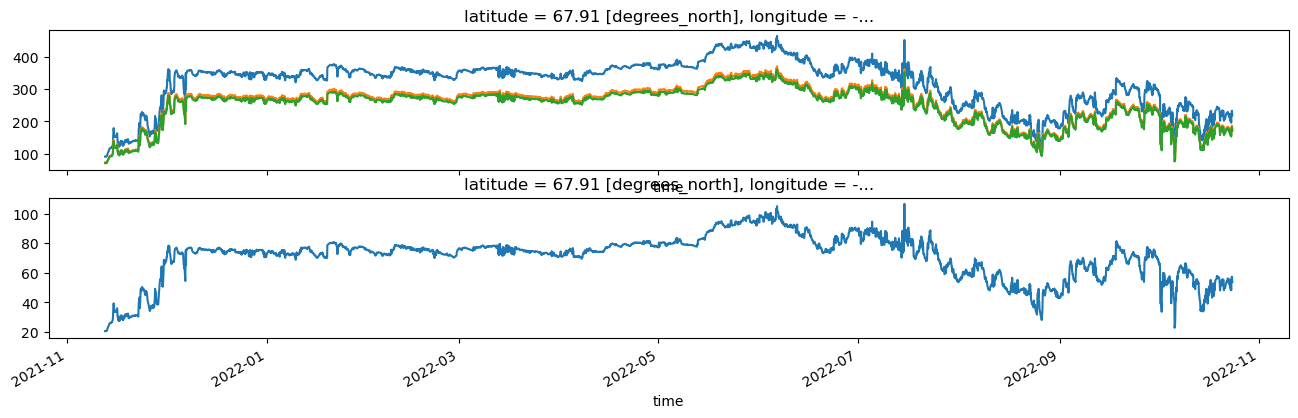

In [22]:
fig, ax = plt.subplots(2,figsize=(16, 4),sharex=True)
rcm_wop_nc.autotrim_time().oxy_conc.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
temp_oxycorr.plot(ax=ax[0])
temp_oxycorr_umkg.plot(ax=ax[0])
temp_oxysat.plot(ax=ax[1])


## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [23]:
#add variables for us to save the datastream above
rcm_wop_nc.add_variable(variable_names=['oxy_percentsat','oxy_conc_umkg'],dupvar='temperature')

#TODO: keep attributes when updating value
rcm_wop_nc.add_external_data('oxy_percentsat',temp_oxysat)
rcm_wop_nc.add_external_data('oxy_conc_umkg',temp_oxycorr_umkg)
rcm_wop_nc.add_external_data('oxy_conc',temp_oxycorr) #will update the orig datastream but currently drops attributes


#add instrument global attributes (again) for new vars
rcm_wop_nc.variable_meta_data(variable_keys=['oxy_percentsat','oxy_conc_umkg','oxy_conc'],drop_missing=False)

In [24]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
rcm_wop_nc.xarray2netcdf_save(xdf = rcm_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe16_wop_nc.xarray2netcdf_save(xdf = sbe16_wop_nc.get_xdf(),
#    filename=filename,format="NETCDF4_CLASSIC")

/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'hours' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})


In [25]:
rcm_wop_nc.get_xdf()

<xarray.Dataset>
Dimensions:         (time: 8360, latitude: 1, longitude: 1, depth: 1)
Coordinates:
  * time            (time) datetime64[ns] 2021-11-09T20:00:00 ... 2022-10-24T...
  * latitude        (latitude) float64 67.91
  * longitude       (longitude) float64 -168.2
  * depth           (depth) float64 54.0
Data variables:
    current_speed   (time, depth, latitude, longitude) float64 0.0 ... 39.3
    u_curr_comp     (time, depth, latitude, longitude) float64 0.0 ... -7.315
    v_curr_comp     (time, depth, latitude, longitude) float64 0.0 ... -38.62
    oxy_conc        (time, depth, latitude, longitude) float64 nan nan ... nan
    temperature     (time, depth, latitude, longitude) float64 21.08 ... 20.23
    pressure        (time, depth, latitude, longitude) float64 -8.149 ... -7.799
    oxy_percentsat  (time, depth, latitude, longitude) float64 nan nan ... nan
    oxy_conc_umkg   (time, depth, latitude, longitude) float64 nan nan ... nan
Attributes: (12/33)
    Latitude_DegMMddW:                      67 54.507 N
    Longitude_DegMMddN:                     168 11.926 W
    MooringID:                              21CKP-12A
    platform_deployment_date:               2021-11-12T13:00:00Z
    platform_deployment_cruise_name:        SKQ2021-15S
    platform_recovery_date:                 2022-10-23T18:57:00Z
    ...                                     ...
    InstrumentSerialNumber:                 651
    InstrumentType:                         RCM9
    date_created:                           2024-02-07T08:45:53Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [26]:
try:
    print(rcm_wop_nc.autotrim_time().pressure.mean())
except:
    print(f'likely no pressure variable in datafile')

<xarray.DataArray 'pressure' ()>
array(1.16108312)


<Figure size 640x480 with 0 Axes>

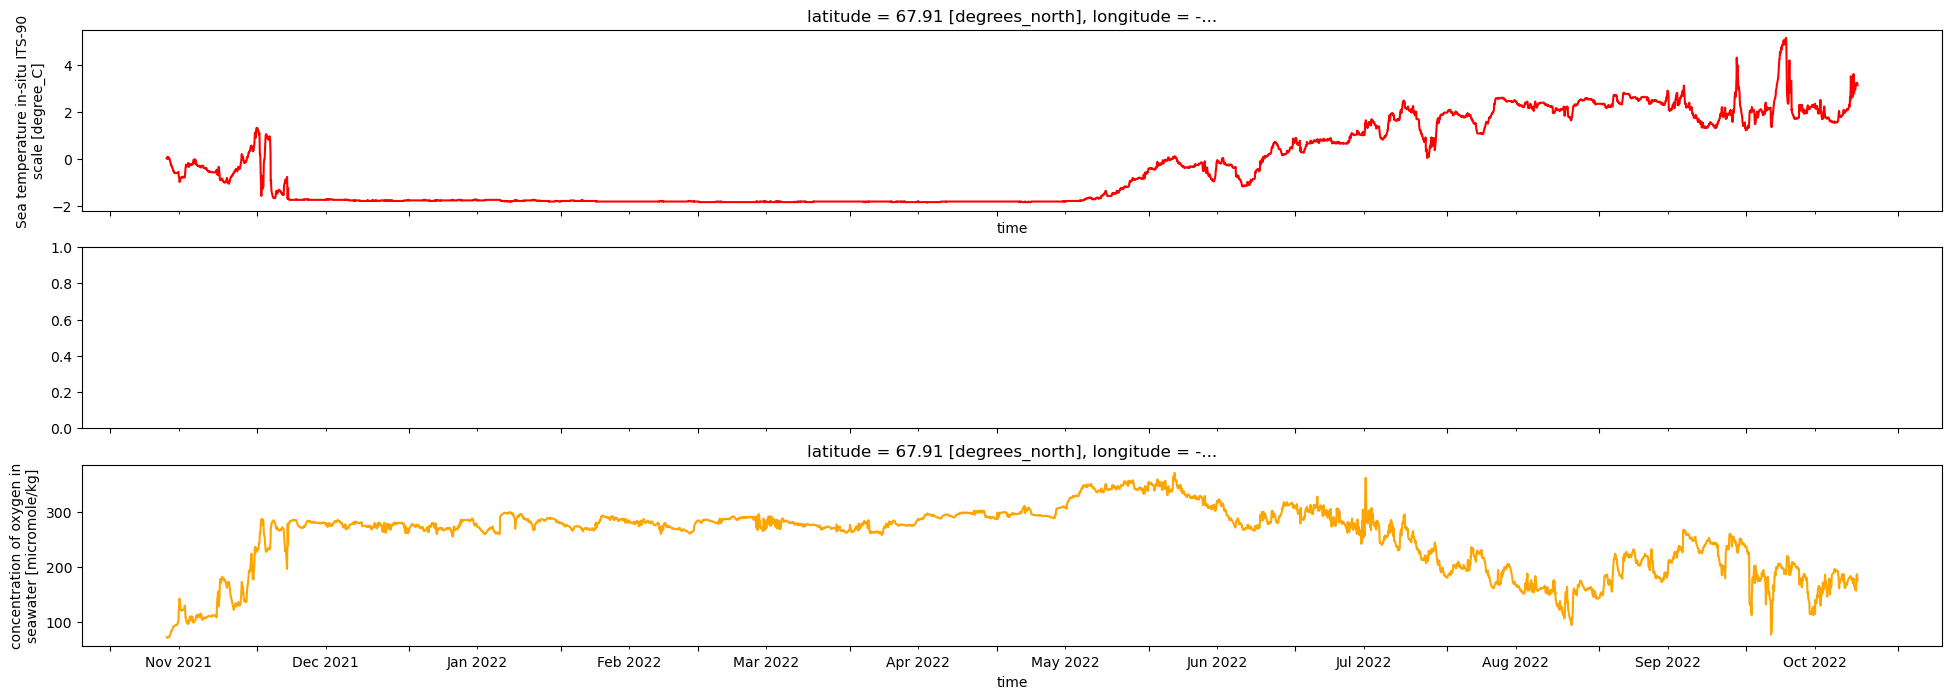

In [27]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
# copy is in the notebook examples
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


fig, ax = plt.subplots(3,figsize=(24, 8),sharex=True)
rcm_wop_nc.autotrim_time().temperature.plot(ax=ax[0],color='r')
# rcm_wop_nc.autotrim_time().salinity.plot(ax=ax[1],color='b')
rcm_wop_nc.autotrim_time().oxy_conc.plot(ax=ax[2],color='orange')

# xfmt = mdates.DateFormatter('%d-%b')
ax[2].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[2].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[2].xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax[2].xaxis.set_major_formatter(DateFormatter(''))
ax[2].xaxis.set_tick_params(which='major', pad=3)
ax[2].xaxis.set_tick_params(which='minor', pad=5)

In [28]:
#csvoutput if necessary - untrimmed for deck analysis
(rcm_wop_nc.get_xdf().to_dataframe()).to_csv(filename.replace('nc','csv'))
#csvoutput of trimmed data for manual edit
(rcm_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','trimmed.csv'))

## Next Steps

QC of data (plot parameters with other instruments)
- There is an oxygen sensor on this unit (see above to perform the salinity/depth corrections)

- be sure to updated the qc_status and the history

In [29]:
import pandas as pd
import xarray as xr
import datetime
import EcoFOCIpy.io.erddap as erddap

url = "http://akutan.pmel.noaa.gov:8082/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [30]:
#grap deploy/recover cast data from erddap hosted sets - you have to know which profile you want though
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='SKQ202115S',qclevel='preliminary',concastno='016')

HTTPError: Error {
    code=404;
    message="Not Found: Currently unknown datasetID=CTD_SKQ202115S_preliminary";
}


In [ ]:
depcast.columns = [x.split(' ')[0] for x in depcast.columns]

In [ ]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])
depth = depcast['pressure'].max()

fig, ax = plt.subplots(3,figsize=(16, 4))
rcm_wop_nc.autotrim_time().temperature.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['T_28'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['T_28'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

rcm_wop_nc.autotrim_time().oxy_conc_umkg.plot(x="time",hue="depth",ax=ax[1], add_legend=False);
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['O_65'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['O_65'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

rcm_wop_nc.autotrim_time().oxy_percentsat.plot(x="time",hue="depth",ax=ax[2], add_legend=False);
ax[2].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['OST_62'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[2].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['OST_62'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

### QC Notes from plots

- rough field check points look good at the large scale
- drop pressure values